# Traffic Sign Detection - Traditional Methods

This notebook implements and evaluates traditional computer vision approaches:
1. HOG + SVM
2. Color + Shape Detection

**Note**: Traditional methods work well on CPU, no GPU needed.

## 1. Setup

In [1]:
# Setup environment (same as data exploration)
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !git clone https://github.com/YOUR_USERNAME/traffic-sign-detection.git
    %cd traffic-sign-detection
else:
    import os
    if os.path.basename(os.getcwd()) == 'notebooks':
        os.chdir('..')

!pip install -q scikit-learn scikit-image opencv-python matplotlib seaborn joblib tqdm

In [3]:
import sys
sys.path.append('src')

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import time

from src.traditional.hog_svm.detector import HOGSVMDetector, SlidingWindowDetector
from src.traditional.color_shape.detector import ColorShapeDetector, SignColor
from src.utils.metrics import DetectionMetrics, SpeedMetrics
from src.utils.visualization import BoundingBoxVisualizer, ResultVisualizer

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Dataset

In [4]:
# Load dataset info
import yaml

data_yaml_path = 'data/raw/yolov8/data.yaml'

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

class_names = data_config['names']
num_classes = data_config['nc']

print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")

# Get image paths
data_root = Path('data/raw/yolov8')
train_images = sorted(list((data_root / 'train' / 'images').glob('*.*')))
val_images = sorted(list((data_root / 'valid' / 'images').glob('*.*')))

print(f"\nTrain images: {len(train_images)}")
print(f"Val images: {len(val_images)}")

Number of classes: 5
Classes: ['bien_bao_cam', 'bien_bao_hieu_lenh', 'bien_bao_nguy_hiem_va_canh_bao', 'bien_chi_dan', 'bien_phu']

Train images: 1062
Val images: 165


## 3. Method 1: HOG + SVM

### 3.1 Prepare Training Data

In [5]:
def extract_patches_from_image(img_path, label_path, img_size=(64, 64)):
    """Extract sign patches from image using YOLO labels"""
    img = cv2.imread(str(img_path))
    if img is None:
        return [], []
    
    h, w = img.shape[:2]
    patches = []
    labels = []
    
    if not label_path.exists():
        return [], []
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:5])
            
            # Convert to pixels
            x1 = max(0, int((cx - bw/2) * w))
            y1 = max(0, int((cy - bh/2) * h))
            x2 = min(w, int((cx + bw/2) * w))
            y2 = min(h, int((cy + bh/2) * h))
            
            # Extract and resize patch
            if x2 > x1 and y2 > y1:
                patch = img[y1:y2, x1:x2]
                patch = cv2.resize(patch, img_size)
                patches.append(patch)
                labels.append(class_id)
    
    return patches, labels

# Extract training patches (limit for speed)
print("Extracting training patches...")
train_patches = []
train_labels = []

max_train_images = min(500, len(train_images))  # Limit for demo

for img_path in tqdm(train_images[:max_train_images]):
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    patches, labels = extract_patches_from_image(img_path, label_path)
    train_patches.extend(patches)
    train_labels.extend(labels)

train_labels = np.array(train_labels)

print(f"Extracted {len(train_patches)} training patches")
print(f"Label distribution: {np.bincount(train_labels)}")

Extracting training patches...


100%|██████████| 500/500 [00:00<00:00, 1113.63it/s]

Extracted 767 training patches
Label distribution: [386  86  87 125  83]


### 3.2 Train HOG+SVM Detector

In [6]:
# Initialize and train detector
print("Training HOG+SVM detector...")

hog_svm = HOGSVMDetector(
    img_size=(64, 64),
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    svm_kernel='rbf',
    svm_c=10.0
)

# Train
start_time = time.time()
hog_svm.train(train_patches, train_labels, class_names=class_names)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

# Save model
hog_svm.save('models/hog_svm_detector.pkl')
print("Model saved!")

Training HOG+SVM detector...
Extracting HOG features from training images...
Training SVM classifier...
Training completed. Model accuracy: 1.000
Training completed in 1.49 seconds
Model saved to models/hog_svm_detector.pkl
Model saved!


### 3.3 Evaluate HOG+SVM

In [7]:
# Test on validation patches
print("Extracting validation patches...")
val_patches = []
val_labels = []

max_val_images = min(100, len(val_images))

for img_path in tqdm(val_images[:max_val_images]):
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    patches, labels = extract_patches_from_image(img_path, label_path)
    val_patches.extend(patches)
    val_labels.extend(labels)

val_labels = np.array(val_labels)

print(f"Extracted {len(val_patches)} validation patches")

# Predict
print("\nRunning predictions...")
pred_classes, confidences = hog_svm.predict_batch(val_patches)

# Calculate accuracy
accuracy = np.mean(pred_classes == val_labels)
print(f"\nClassification Accuracy: {accuracy:.3f}")

# Per-class accuracy
print("\nPer-class Accuracy:")
for class_id in range(num_classes):
    mask = val_labels == class_id
    if mask.sum() > 0:
        class_acc = np.mean(pred_classes[mask] == val_labels[mask])
        print(f"  {class_names[class_id]}: {class_acc:.3f} ({mask.sum()} samples)")

Extracting validation patches...


100%|██████████| 100/100 [00:00<00:00, 1175.30it/s]

Extracted 154 validation patches

Running predictions...



Classification Accuracy: 0.942

Per-class Accuracy:
  bien_bao_cam: 0.956 (68 samples)
  bien_bao_hieu_lenh: 0.875 (8 samples)
  bien_bao_nguy_hiem_va_canh_bao: 0.969 (32 samples)
  bien_chi_dan: 0.962 (26 samples)
  bien_phu: 0.850 (20 samples)


### 3.4 Visualize HOG Features

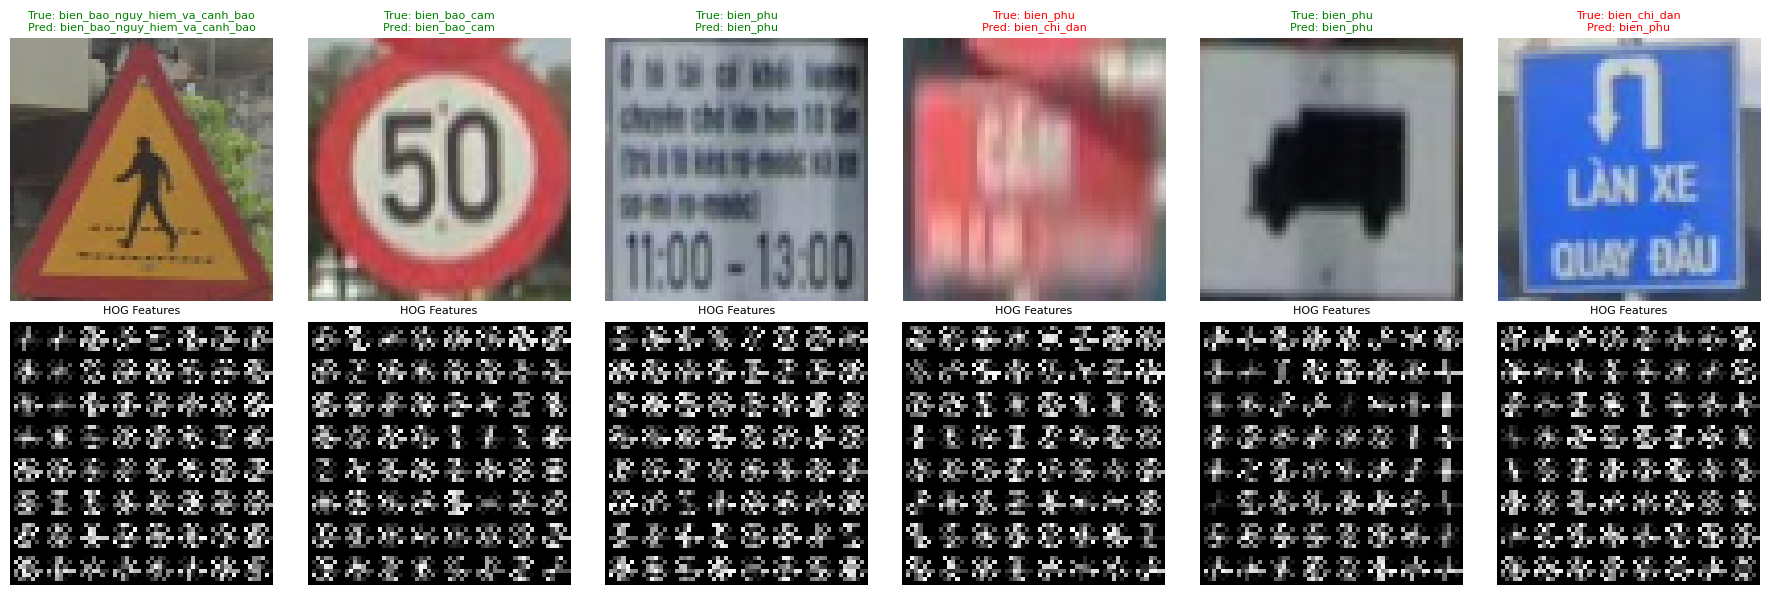

In [8]:
# Visualize HOG features for sample patches
n_samples = 6
sample_indices = np.random.choice(len(val_patches), n_samples, replace=False)

fig, axes = plt.subplots(2, n_samples, figsize=(18, 6))

for idx, sample_idx in enumerate(sample_indices):
    patch = val_patches[sample_idx]
    true_label = val_labels[sample_idx]
    pred_label = pred_classes[sample_idx]
    
    # Original image
    axes[0, idx].imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
    color = 'green' if true_label == pred_label else 'red'
    axes[0, idx].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                          fontsize=8, color=color)
    axes[0, idx].axis('off')
    
    # HOG visualization
    hog_img = hog_svm.visualize_hog(patch)
    axes[1, idx].imshow(hog_img, cmap='gray')
    axes[1, idx].set_title('HOG Features', fontsize=8)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

## 4. Method 2: Color + Shape Detection

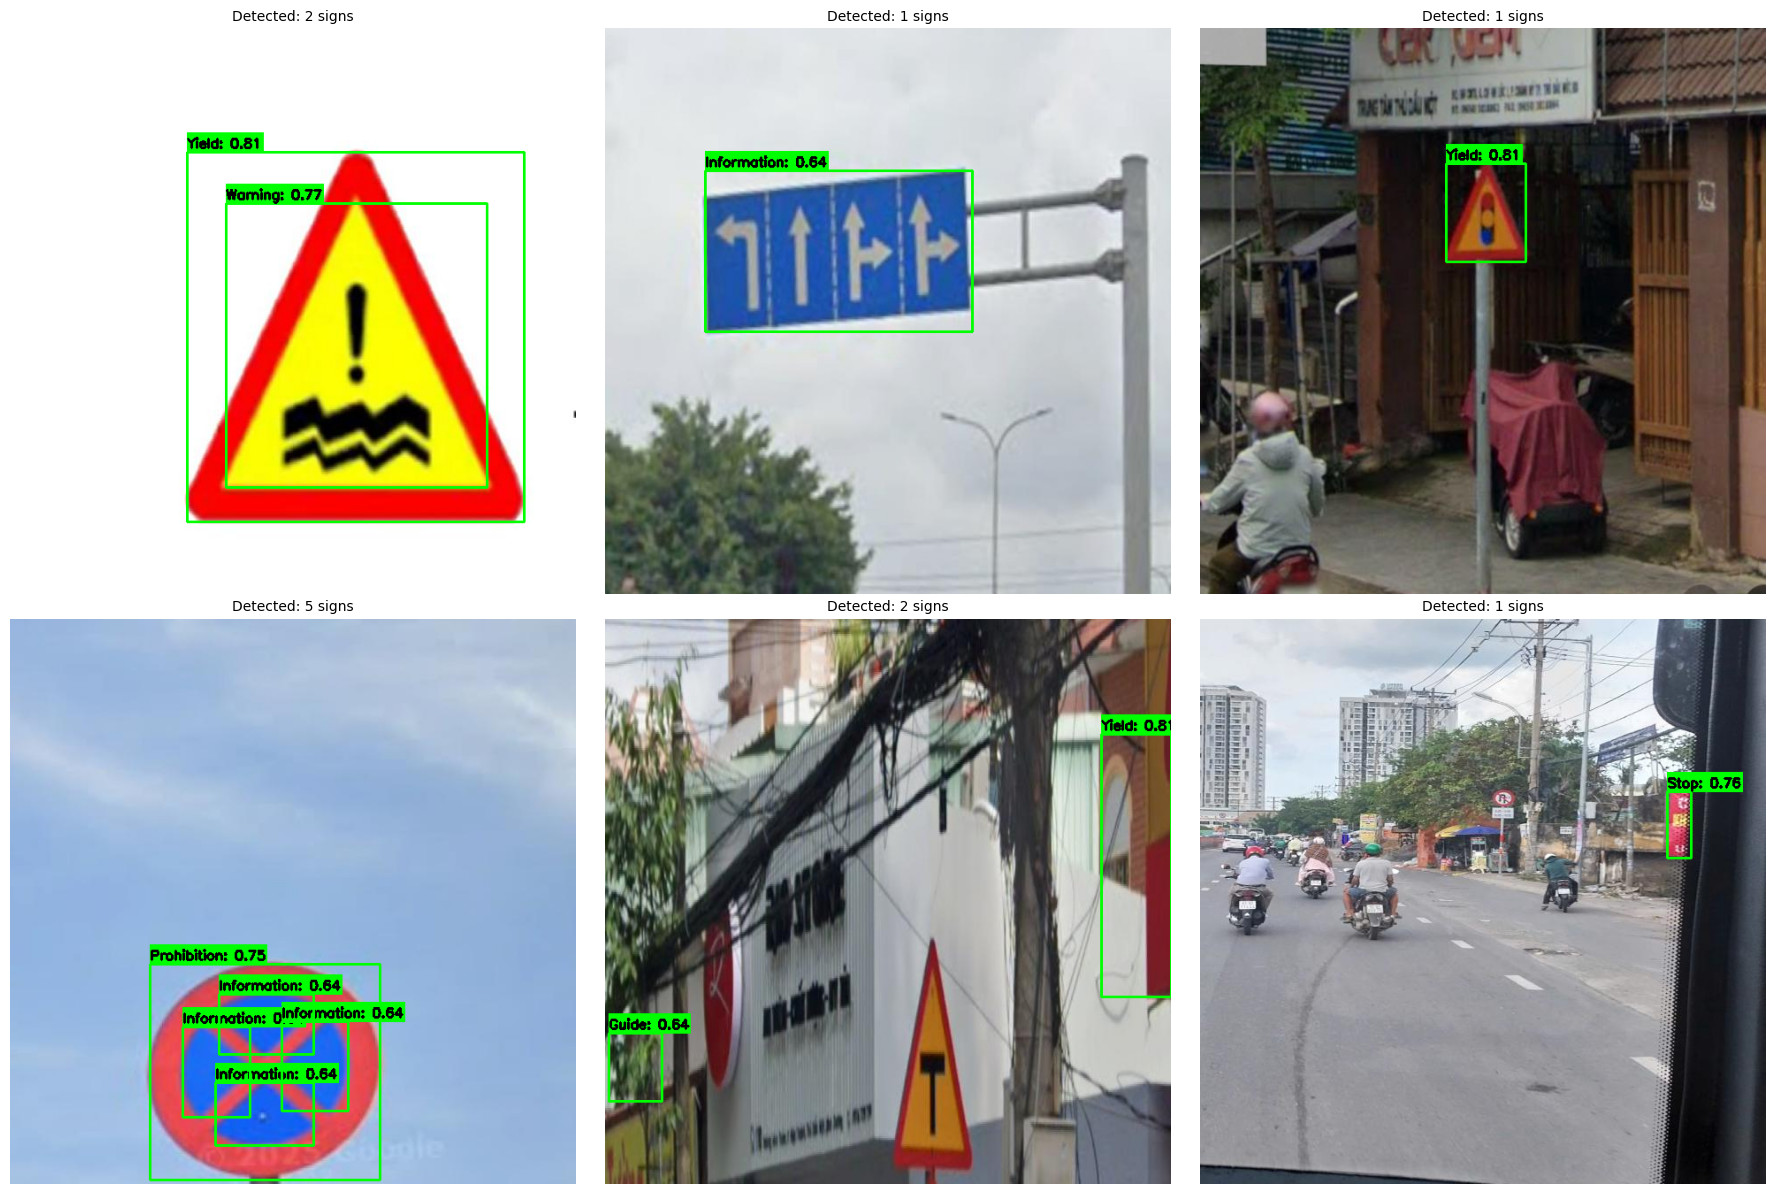

Color+Shape detection completed!
Note: This method works best for standard sign colors (red, blue, yellow)


In [9]:
# Initialize color-shape detector
color_shape = ColorShapeDetector()

# Test on sample images
n_test_images = 6
test_image_paths = np.random.choice(val_images, n_test_images, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(test_image_paths):
    # Load image
    img = cv2.imread(str(img_path))
    
    # Detect
    boxes, types, confidences = color_shape.detect(
        img,
        confidence_threshold=0.5,
        min_area=500
    )
    
    # Visualize
    result = color_shape.visualize_detection(img, boxes, types, confidences)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(result)
    axes[idx].set_title(f"Detected: {len(boxes)} signs", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Color+Shape detection completed!")
print("Note: This method works best for standard sign colors (red, blue, yellow)")

## 5. Performance Comparison

In [10]:
# Compare inference speed
n_speed_tests = 50
speed_test_images = val_patches[:n_speed_tests]

# HOG+SVM speed
print("Testing HOG+SVM speed...")
hog_times = []
for img in tqdm(speed_test_images):
    start = time.time()
    _ = hog_svm.predict(img)
    hog_times.append(time.time() - start)

hog_avg_time = np.mean(hog_times) * 1000  # ms
hog_fps = 1.0 / np.mean(hog_times)

print(f"\nHOG+SVM Performance:")
print(f"  Avg inference time: {hog_avg_time:.2f} ms")
print(f"  FPS: {hog_fps:.1f}")
print(f"  Accuracy: {accuracy:.3f}")

# Summary table
import pandas as pd

results = pd.DataFrame({
    'Method': ['HOG+SVM'],
    'Accuracy': [f"{accuracy:.3f}"],
    'Inference Time (ms)': [f"{hog_avg_time:.2f}"],
    'FPS': [f"{hog_fps:.1f}"]
})

print("\n" + "="*60)
print("TRADITIONAL METHODS PERFORMANCE SUMMARY")
print("="*60)
print(results.to_string(index=False))
print("="*60)

Testing HOG+SVM speed...


100%|██████████| 50/50 [00:00<00:00, 551.25it/s]


HOG+SVM Performance:
  Avg inference time: 1.81 ms
  FPS: 552.9
  Accuracy: 0.942

TRADITIONAL METHODS PERFORMANCE SUMMARY
 Method Accuracy Inference Time (ms)   FPS
HOG+SVM    0.942                1.81 552.9


## 6. Conclusions

**HOG + SVM:**
- Pros: Fast, interpretable, works on CPU
- Cons: Requires careful feature engineering, lower accuracy than deep learning
- Best for: Real-time applications on embedded systems

**Color + Shape:**
- Pros: Very fast, no training required, interpretable
- Cons: Limited to standard colors/shapes, sensitive to lighting
- Best for: Quick prototyping, controlled environments

**Next**: Run `03_modern_methods.ipynb` to see how deep learning models compare!